# **MOIRAI TEST**

## **Import Libraries**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys

current_dir = os.getcwd()
PROJECT_DIR = os.path.abspath(os.path.join(current_dir, '..'))
if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)
BASE_DIR = os.path.basename(PROJECT_DIR)

print(f"Project path (Relative): {BASE_DIR}")

Project path (Relative): foundation-moirai-time-series-forecasting


In [4]:
import yaml
import pandas as pd

In [5]:
from src.dataloader import load_data, get_splits
from src.baselines import BaselineModels
from src.moirai_wrapper import MoiraiPredictor
from src.evaluation import rolling_cv, statistical_test
from src.plotting import *

## **Setup Figurations**

In [6]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device using: {DEVICE}")

Device using: cuda


In [7]:
os.makedirs(f'{PROJECT_DIR}/outputs', exist_ok=True)
OUTPUTS_DIR = f"{PROJECT_DIR}/outputs"
BASE_OUTPUT = os.path.basename(OUTPUTS_DIR)
if os.path.isdir(OUTPUTS_DIR):
    print(f"Detected output folder: {BASE_OUTPUT}")
else:
    print(f"Cannot detect output folder")

Detected output folder: outputs


In [8]:
CONFIGS_DIR = f"{PROJECT_DIR}/configs/config.yaml"
with open(CONFIGS_DIR, "r") as f:
    config = yaml.safe_load(f)

SPY_DATASET, AQI_DATASET = config['datasets']

In [9]:
MOIRAI_SMALL = config['models']['moirai_small']
MOIRAI_BASE = config['models']['moirai_base']

In [10]:
HORIZON = config['experiment']['horizon']
CONTEXT_LENGTH = config['experiment']['context_length']

print(f"Horizon: {HORIZON}")
print(f"Context length: {CONTEXT_LENGTH}")

Horizon: 60
Context length: 60


## **YahooFinance - SPY**

### **Load Data**

In [11]:
df = load_data(SPY_DATASET, config)
df.head()

,values
date,
2015-01-02,170.589630
2015-01-05,167.508789
2015-01-06,165.931091
2015-01-07,167.998795
2015-01-08,170.979889


In [12]:
train_spy, valid_spy, test_spy = get_splits(df, config)

Splits created:
- train: 2367
- valid: 180
-  test: 60



### **Initialize Models**

In [13]:
SEASONALITY = config['datasets'][SPY_DATASET]['seasonality']
FREQ = config['datasets'][SPY_DATASET].get('frequency', 'D')

print(f"- Seasonality: {SEASONALITY}")
print(f"-   Frequency: {FREQ}")

- Seasonality: 5
-   Frequency: B


In [14]:
baselines = BaselineModels(
    seasonal_period=SEASONALITY,
    horizon=HORIZON)

moirai_models = {
    'Moirai-Small': MoiraiPredictor(
        model_name=MOIRAI_SMALL,
        context_length=CONTEXT_LENGTH,
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ),
    
    'Moirai-Base': MoiraiPredictor(
        model_name=MOIRAI_BASE,
        context_length=CONTEXT_LENGTH,
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ)
}

### **Backtesting**

In [15]:
valid_results, preds = rolling_cv(
    train_series=train_spy['values'],
    valid_series=valid_spy['values'],
    baselines=baselines,
    moirai_models=moirai_models,
    config=config)

[FOLD 1]: Predict 2023-11-07 to 2024-01-29
[FOLD 2]: Predict 2024-01-30 to 2024-04-22
[FOLD 3]: Predict 2024-04-23 to 2024-07-15


### **Stats**

In [16]:
print(f"[{SPY_DATASET}] Results Summary (MAE):")
print(valid_results.groupby('model')['MAE'].mean())

[SPY] Results Summary (MAE):
model
ETS             23.356130
Moirai-Base     28.715223
Moirai-Small    22.839669
S-Naive         30.431957
Name: MAE, dtype: float64


In [17]:
best_bl, best_moirai, p_val = statistical_test(valid_results)
print(f"Wilcoxon: {best_moirai} vs {best_bl}\n- p={p_val:.4f}")

Wilcoxon: Moirai-Small vs ETS
- p=0.7500


### **Plots**

Plot saved: outputs\01_spy_backtesting.png


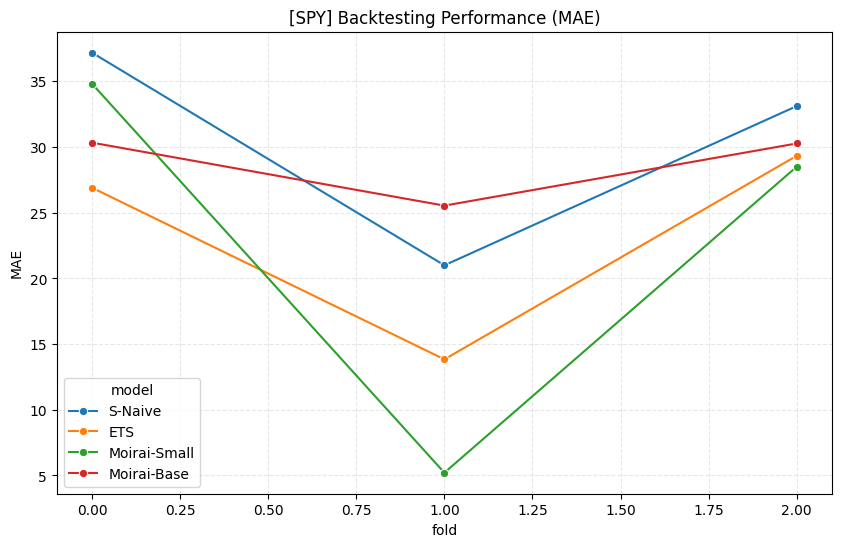

In [18]:
plot_backtesting_perf(valid_results, SPY_DATASET)

Plot saved: outputs\02_spy_horizon_error.png


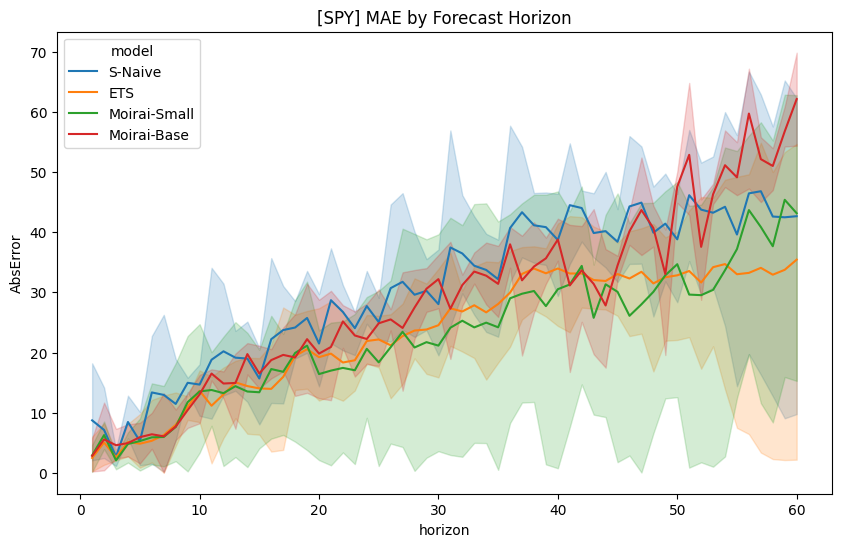

In [19]:
plot_error_by_horizon(preds, SPY_DATASET)

Plot saved: outputs\03_spy_calibration.png


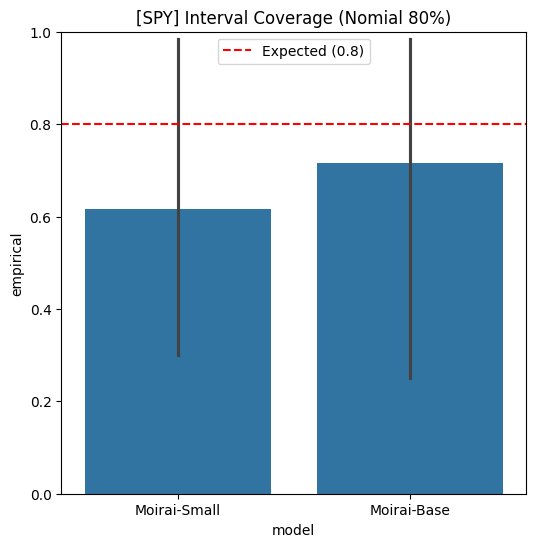

In [20]:
plot_calibration(preds, SPY_DATASET)

### **Final Inference**

In [21]:
full_history = pd.concat([train_spy['values'], valid_spy['values']])
final_preds = {}

In [22]:
for name, model in moirai_models.items():
    context = full_history.iloc[-CONTEXT_LENGTH:]
    final_preds[name] = model.predict(context)

Plot saved: outputs\04_spy_overlay_prediction.png


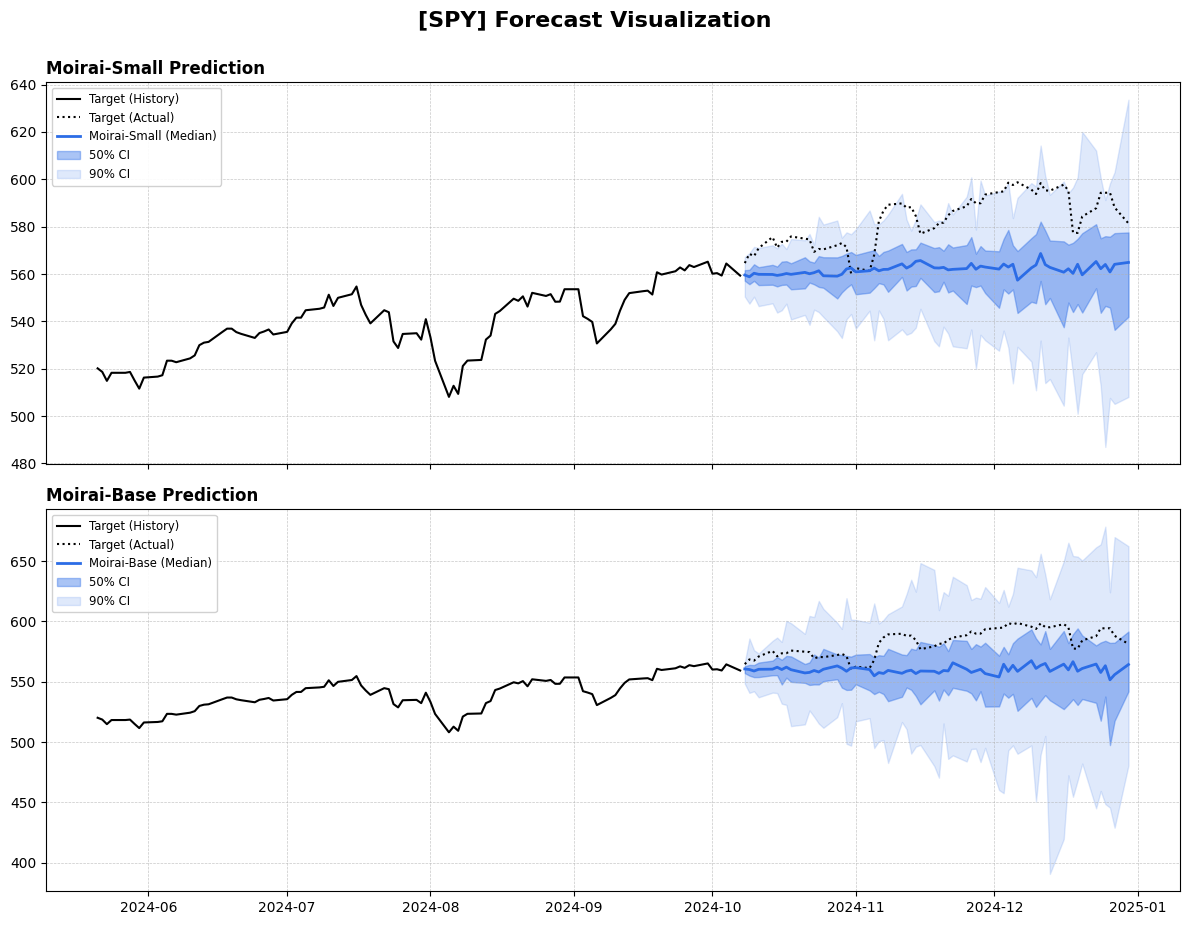

In [23]:
plot_forecast_overlay(full_history, test_spy['values'], final_preds, SPY_DATASET)

## **AQI - LA**

### **Load Data**

In [24]:
df = load_data(AQI_DATASET, config)
df.head()

,values
date,
2022-08-10,277
2022-08-11,155
2022-08-12,291
2022-08-13,291
2022-08-14,290


In [25]:
train_aqi, valid_aqi, test_aqi = get_splits(df, config)

Splits created:
- train: 635
- valid: 180
-  test: 60



### **Initialize Models**

In [26]:
SEASONALITY = config['datasets'][AQI_DATASET]['seasonality']
FREQ = config['datasets'][AQI_DATASET].get('frequency', 'D')

print(f"- Seasonality: {SEASONALITY}")
print(f"-   Frequency: {FREQ}")

- Seasonality: 7
-   Frequency: D


In [27]:
baselines = BaselineModels(
    seasonal_period=SEASONALITY,
    horizon=HORIZON)

moirai_models = {
    'Moirai-Small': MoiraiPredictor(
        model_name=MOIRAI_SMALL,
        context_length=CONTEXT_LENGTH,
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ),
    
    'Moirai-Base': MoiraiPredictor(
        model_name=MOIRAI_BASE,
        context_length=CONTEXT_LENGTH,
        horizon=HORIZON,
        device=DEVICE,
        freq=FREQ)
}

### **Backtesting**

In [28]:
valid_results, preds = rolling_cv(
    train_series=train_aqi['values'],
    valid_series=valid_aqi['values'],
    baselines=baselines,
    moirai_models=moirai_models,
    config=config)

[FOLD 1]: Predict 2024-03-07 to 2024-05-05
[FOLD 2]: Predict 2024-05-06 to 2024-07-04
[FOLD 3]: Predict 2024-07-05 to 2024-09-02


### **Stats**

In [29]:
print(f"[{AQI_DATASET}] Results Summary (MAE):")
print(valid_results.groupby('model')['MAE'].mean())

[AQI_LA] Results Summary (MAE):
model
ETS             20.639549
Moirai-Base     15.265919
Moirai-Small    15.066542
S-Naive         23.077778
Name: MAE, dtype: float64


In [30]:
best_bl, best_moirai, p_val = statistical_test(valid_results)
print(f"Wilcoxon: {best_moirai} vs {best_bl}\n- p={p_val:.4f}")

Wilcoxon: Moirai-Small vs ETS
- p=0.2500


### **Plots**

Plot saved: outputs\01_aqi_la_backtesting.png


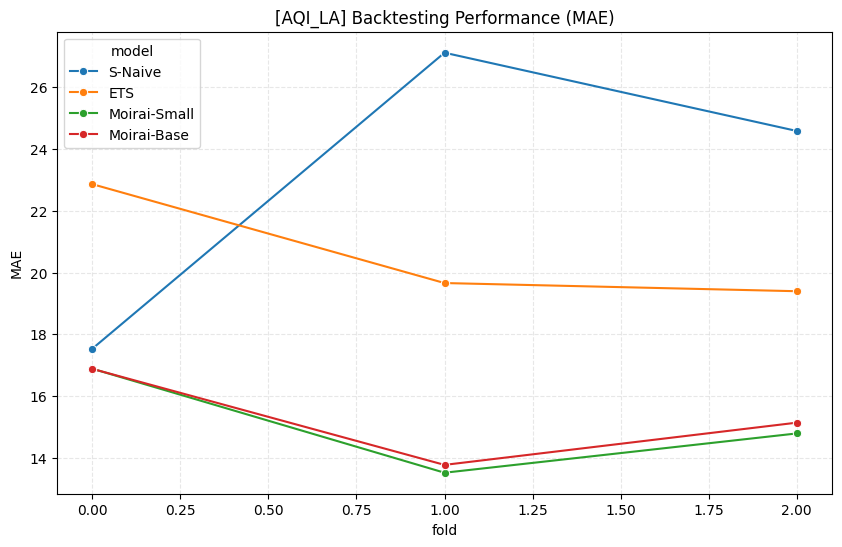

In [31]:
plot_backtesting_perf(valid_results, AQI_DATASET)

Plot saved: outputs\02_aqi_la_horizon_error.png


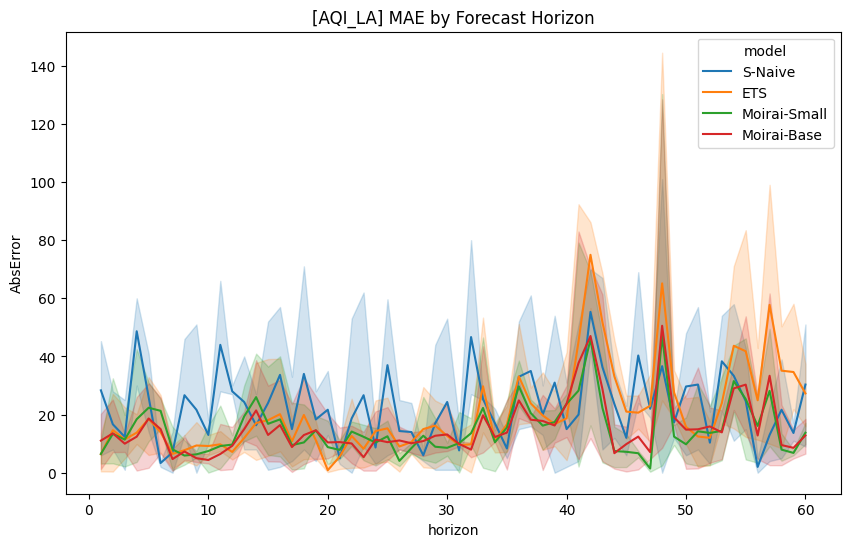

In [32]:
plot_error_by_horizon(preds, AQI_DATASET)

Plot saved: outputs\03_aqi_la_calibration.png


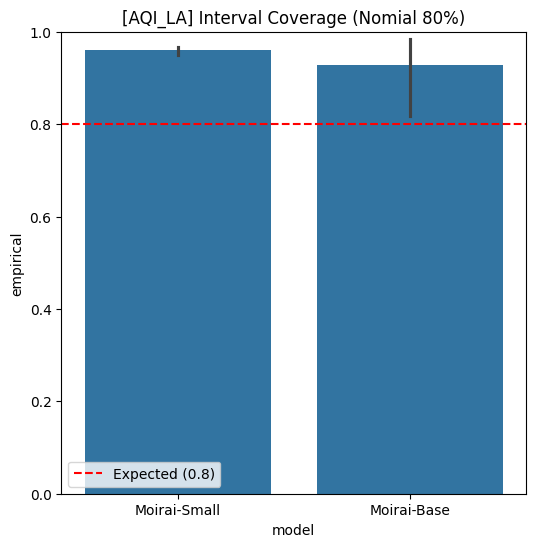

In [33]:
plot_calibration(preds, AQI_DATASET)

### **Final Inference**

In [34]:
full_history = pd.concat([train_aqi['values'], valid_aqi['values']])
final_preds = {}

In [35]:
for name, model in moirai_models.items():
    context = full_history.iloc[-CONTEXT_LENGTH:]
    final_preds[name] = model.predict(context)

Plot saved: outputs\04_aqi_la_overlay_prediction.png


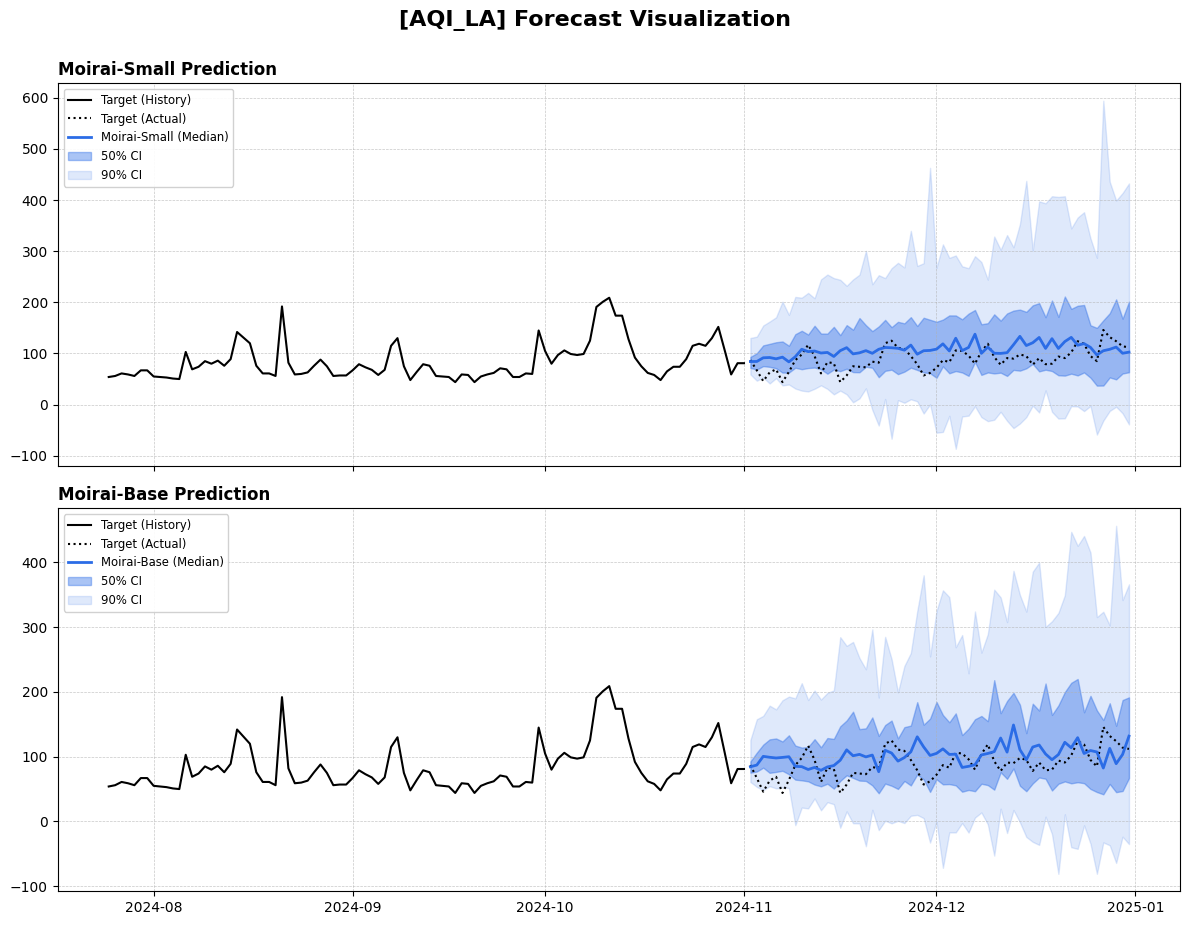

In [36]:
plot_forecast_overlay(full_history, test_aqi['values'], final_preds, AQI_DATASET)